In [48]:
#importing library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [34]:
#loading the dataset
df=pd.read_csv('../input/apartment-rental-offers-in-germany/immo_data.csv')
#showing the dataset
df

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,...,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,...,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,...,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,...,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,...,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,...,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268845,Bayern,90.00,heat_pump,ONE_YEAR_FREE,NaN,False,True,0,2.74,10.0,...,Weilheim_Schongau_Kreis,Eberfing,"Diese schöne, neuwertige Wohnung im Dachgescho...",Fliesen und Parkett. Sichtbarer Dachstuhl.,NaN,NaN,NaN,NaN,NaN,Feb20
268846,Hessen,220.00,gas_heating,NaN,NaN,False,True,12,6.49,NaN,...,Bergstraße_Kreis,Viernheim,Hier wird eine Wohnung im 2 Familienhaus angeb...,"Parkett, Kamin, Badewanne&Dusche\nGroßer Balko...",NaN,NaN,2015.0,NaN,NaN,May19
268847,Hessen,220.00,central_heating,ONE_YEAR_FREE,NaN,False,True,21,2.90,40.0,...,Limburg_Weilburg_Kreis,Limburg_an_der_Lahn,gemütliche 4-Zimmer-Wohnung im Obergeschoss ei...,"Böden: Wohn-/Schlafbereich = Laminat, Küche + ...",NaN,NaN,2019.0,NaN,NaN,Feb20
268848,Nordrhein_Westfalen,175.00,heat_pump,NaN,NaN,True,True,16,4.39,NaN,...,Köln,Dellbrück,"Neubau Erstbezug, gehobener Standard, alle Ein...","Wände:\nMaler­vlies, weiß gestrichen alter­nat...",40.00,NO_INFORMATION,2019.0,NaN,NaN,May19


In [35]:
#getting information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

In [36]:
def onehot_encode(df,column):
    #creating the copy of the dataframe
    df=df.copy()
    #creating dummies column from orginal columns
    dummies=pd.get_dummies(df[column],prefix=column)
    #concating the dummies column with original dataframe
    df=pd.concat([df,dummies],axis=1)
    df=df.drop(column,axis=1)
    #returning the original 
    return df
    

In [37]:
#Helper functions
def preprocess_inputs(df):
    #copying the datset
    df=df.copy()
    
    #dropping the high cardinality columns
    df=df.drop(['houseNumber','street','streetPlain','regio3','description','facilities'],axis=1)
    #Drop columns with more thea 25% missing values
    missing_value_columns=df.loc[:,df.isna().mean()>0.25].columns
    #dropping the missing value columns
    df=df.drop(missing_value_columns,axis=1)
    
    #Drop examples with missing label valules
    missing_label_rows=df.loc[df['typeOfFlat'].isna(),:].index
    df=df.drop(missing_label_rows,axis=0).reset_index(drop=True)
    
    #creating a new column with 1 and 0 whether this is apartment or flat
    #Drop examples 
    df['isApartment']=df['typeOfFlat'].apply(lambda x: 1 if x=='apartment' else 0)
    #After it droppingn the original column
    df=df.drop('typeOfFlat',axis=1)
    # Geting columns with remaining missing values
    remaining_na_columns=df.loc[:,df.isna().sum()>0]
    #Deleting the original object columns with missing values
    
    categorical_na_columns=remaining_na_columns.select_dtypes('object').columns
    #numerical missing values 
    numeric_na_columns=remaining_na_columns.drop(categorical_na_columns,axis=1).columns
    #Filling numeric missing values with column mean
    for column in numeric_na_columns:
        df[column]=(df[column].fillna(df[column].mean()))
    for column in categorical_na_columns:
        df[column]=df[column].fillna("missing")
    for column in df.columns:
        if df[column].dtype=='bool':
            df[column]=df[column].astype(np.int)
    #Extract date features
    df['date']=pd.to_datetime(df['date'],format='%b%y')
    df['year']=df['date'].apply(lambda x:x.year)
    df['month']=df['date'].apply(lambda x:x.month)
    df=df.drop('date',axis=1)
    #One-hot encode
    for column in df.select_dtypes('object'):
        df=onehot_encode(df,column)
    #scaling th dataset
    #Splitting df into x and y
    y=df['isApartment']
    x=df.drop('isApartment',axis=1)
    #train_test_split
    x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7,random_state=1)
    scaler=StandardScaler()
    scaler.fit(x_train)
    x_train=pd.DataFrame(scaler.transform(x_train),columns=x_train.columns,index=x_train.index)
    x_test=pd.DataFrame(scaler.transform(x_test),columns=x_test.columns,index=x_test.index)
    #returning the dataset
    return x_train,x_test,y_train,y_test




In [39]:
x_train,x_test,y_train,y_test=preprocess_inputs(df)
x_train

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,serviceCharge,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,hasKitchen,...,regio2_Wolfsburg,regio2_Worms,regio2_Wunsiedel_im_Fichtelgebirge_Kreis,regio2_Wuppertal,regio2_Würzburg,regio2_Würzburg_Kreis,regio2_Zollernalbkreis,regio2_Zweibrücken,regio2_Zwickau,regio2_Zwickau_Kreis
231082,-0.185058,-0.298941,0.771024,1.568742,-1.684659,0.728683,-0.010576,0.214721,0.437931,-0.745806,...,-0.035359,-0.028181,-0.01664,-0.098338,-0.034566,-0.025903,-0.022465,-0.018059,-0.093035,-0.087351
152378,-0.274183,-0.298941,0.771024,-0.299177,-0.093462,0.728683,-0.009535,0.001652,0.547111,-0.745806,...,-0.035359,-0.028181,-0.01664,-0.098338,-0.034566,-0.025903,-0.022465,-0.018059,-0.093035,-0.087351
211119,-0.000257,-0.298941,0.771024,-1.544457,-0.191620,0.728683,-0.009027,0.001652,-0.085761,-0.745806,...,-0.035359,-0.028181,-0.01664,-0.098338,-0.034566,-0.025903,-0.022465,-0.018059,-0.093035,-0.087351
119441,0.027269,-0.298941,0.771024,-0.766157,-0.207119,-1.239998,-0.007377,0.777060,0.353798,-0.745806,...,-0.035359,-0.028181,-0.01664,-0.098338,-0.034566,-0.025903,-0.022465,-0.018059,-0.093035,-0.087351
192575,-0.090690,-0.298941,-1.296977,-0.299177,0.707304,0.728683,-0.000897,-0.417910,-4.234002,-0.745806,...,-0.035359,-0.028181,-0.01664,-0.098338,-0.034566,-0.025903,-0.022465,-0.018059,-0.093035,-0.087351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229119,-0.195544,3.345136,0.771024,-0.143518,-0.258781,-1.738731,-0.000897,1.198814,0.538023,-0.745806,...,-0.035359,-0.028181,-0.01664,-0.098338,-0.034566,-0.025903,-0.022465,-0.018059,-0.093035,-0.087351
5192,-0.221757,-0.298941,-1.296977,0.012142,-0.728907,0.728683,-0.013851,-0.113310,-3.261278,-0.745806,...,-0.035359,-0.028181,-0.01664,-0.098338,-0.034566,-0.025903,-0.022465,-0.018059,-0.093035,-0.087351
208780,-0.050217,3.345136,-1.296977,0.167802,1.337583,0.000238,0.003032,1.198814,0.212770,-0.745806,...,-0.035359,-0.028181,-0.01664,-0.098338,-0.034566,-0.025903,-0.022465,-0.018059,-0.093035,-0.087351
229611,-0.000257,3.345136,0.771024,-0.143518,0.097689,-1.738731,-0.002934,1.245676,0.696387,-0.745806,...,-0.035359,-0.028181,-0.01664,-0.098338,-0.034566,-0.025903,-0.022465,-0.018059,-0.093035,-0.087351


In [ ]:
#checking the length of unique value in each column
{column:len(x[column].unique()) for column in x.select_dtypes('object')}

In [ ]:
x.isna().sum()

In [ ]:
x.loc[:,x.isna().mean()>0.25].columns

In [ ]:
x.loc

In [ ]:
x

In [ ]:
x_train.isna().sum()

In [ ]:
#Training
x_train.shape

In [40]:
inputs=tf.keras.Input(shape=(x_train.shape[1],))
x=tf.keras.layers.Dense(128,activation='relu')(inputs)
x=tf.keras.layers.Dense(128,activation='relu')(x)
outputs=tf.keras.layers.Dense(1,activation='sigmoid')(x)
model=tf.keras.Model(inputs=inputs,outputs=outputs)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1036)]            0         
_________________________________________________________________
dense (Dense)                (None, 128)               132736    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 149,377
Trainable params: 149,377
Non-trainable params: 0
_________________________________________________________________
None


2022-05-20 09:42:42.531382: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [41]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ])

history=model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
        
    )])



2022-05-20 09:42:56.302145: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
4065/4065 [==============================] - 16s 4ms/step - loss: 0.6555 - accuracy: 0.6121 - auc: 0.6429 - val_loss: 0.6403 - val_accuracy: 0.6250 - val_auc: 0.6644
Epoch 2/100
4065/4065 [==============================] - 14s 3ms/step - loss: 0.6279 - accuracy: 0.6392 - auc: 0.6882 - val_loss: 0.6148 - val_accuracy: 0.6573 - val_auc: 0.7116
Epoch 3/100
4065/4065 [==============================] - 13s 3ms/step - loss: 0.5909 - accuracy: 0.6815 - auc: 0.7426 - val_loss: 0.5896 - val_accuracy: 0.6812 - val_auc: 0.7452
Epoch 4/100
4065/4065 [==============================] - 14s 3ms/step - loss: 0.5695 - accuracy: 0.6981 - auc: 0.7667 - val_loss: 0.5810 - val_accuracy: 0.6886 - val_auc: 0.7587
Epoch 5/100
4065/4065 [==============================] - 13s 3ms/step - loss: 0.5573 - accuracy: 0.7067 - auc: 0.7790 - val_loss: 0.5704 - val_accuracy: 0.6965 - val_auc: 0.7663
Epoch 6/100
4065/4065 [==============================] - 13s 3ms/step - loss: 0.5471 - accuracy: 0.7149 - auc:

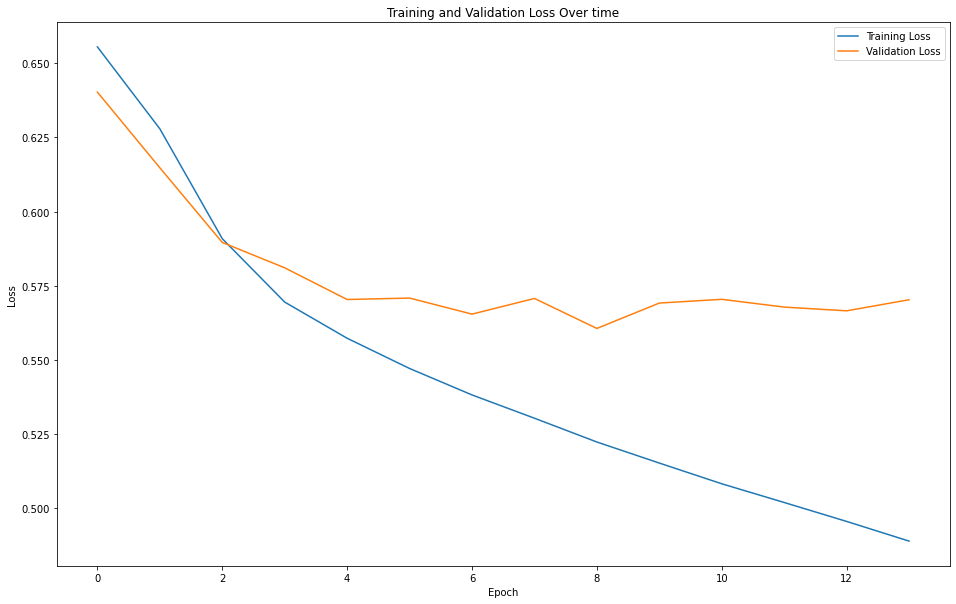

In [45]:
epochs_range=range(len(history.history['loss']))
plt.figure(figsize=(16,10))
plt.plot(epochs_range,history.history['loss'],label='Training Loss')
plt.plot(epochs_range,history.history['val_loss'],label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Training and Validation Loss Over time')
plt.legend()
plt.show()

In [46]:
#Preprocessing 
def evaluate_model(mode,x_test,y_test):
    results=model.evaluate(x_test,y_test,verbose=0)
    print("Test loss: {:.4f}".format(results[0]))
    print("Test Accuracy: {:2f}%".format(results[1]*100))
    print("   Test AUCL:{:.4f}".format(results[2]))
    y_pred=np.array(model.predict(x_test)>=0.5,dtype=np.int)
    
    cm=confusion_matrix()
    clr=classification_report(y_test,y_pred,target_values=["Not Apartment","Apartment"])
    plt.figure(figsize=(6,6))
    sns.heatmap(cm,annot=True,fmt="g",cmap='Blues',cbar=False)
    plt.snow()
    print("Classification Report")
    
    
    
    
    
    
    

In [49]:
evaluate_model(model,x_test,y_test)

Test loss: 0.5621
Test Accuracy: 70.920467%
   Test AUCL:0.7787


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


TypeError: confusion_matrix() missing 2 required positional arguments: 'y_true' and 'y_pred'